In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Load the Energy Efficiency dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
data = pd.read_excel(url)

# Column Names
data.columns = [
    "Relative Compactness", "Surface Area", "Wall Area", "Roof Area", 
    "Overall Height", "Orientation", "Glazing Area", "Glazing Area Distribution", 
    "Heating Load", "Cooling Load"
]

# Select Features and Target
X = data.iloc[:, :-2].values  # First 8 columns (features)
y_heating = data.iloc[:, -2].values  # Heating Load target

# Step 2: Train-Test Split and Scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y_heating, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print("Data Loaded and Preprocessed:")
print(f"Training Samples: {X_train.shape[0]}, Validation Samples: {X_val.shape[0]}, Test Samples: {X_test.shape[0]}")


Data Loaded and Preprocessed:
Training Samples: 537, Validation Samples: 115, Test Samples: 116


In [15]:
# Corrected definition for inner networks (ψ_qp)
def create_inner_network(hidden_units):
    inputs = layers.Input(shape=(1,))
    x = layers.Dense(hidden_units, activation="relu")(inputs)
    x = layers.Dense(hidden_units, activation="relu")(x)
    outputs = layers.Dense(1)(x)
    return models.Model(inputs, outputs, name="Inner_Network")


In [16]:
# Define the outer networks (Φ_q)
def create_outer_network(hidden_units):
    inputs = layers.Input(shape=(1,))
    x = layers.Dense(hidden_units, activation="relu")(inputs)
    x = layers.Dense(hidden_units, activation="relu")(x)
    outputs = layers.Dense(1)(x)
    return models.Model(inputs, outputs, name="Outer_Network")


In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

class KolmogorovArnoldNetwork(tf.keras.Model):
    def __init__(self, input_dim, num_outer, hidden_units_inner, hidden_units_outer):
        super(KolmogorovArnoldNetwork, self).__init__()
        self.inner_networks = [
            create_inner_network(hidden_units_inner) for _ in range(input_dim)
        ]
        self.outer_networks = [
            create_outer_network(hidden_units_outer) for _ in range(num_outer)
        ]

    def call(self, inputs):
        # Compute inner sums (ψ_qp)
        inner_sums = []
        for i in range(len(self.outer_networks)):
            inner_sum = tf.add_n(
                [self.inner_networks[j](inputs[:, j:j+1]) for j in range(len(self.inner_networks))]
            )
            inner_sums.append(inner_sum)
        
        # Compute outer functions (Φ_q)
        outer_sums = tf.add_n(
            [self.outer_networks[k](inner_sums[k]) for k in range(len(self.outer_networks))]
        )
        return outer_sums


In [18]:
# Define the Kolmogorov-Arnold Network (KAN) as implemented earlier
kan_model = KolmogorovArnoldNetwork(
    input_dim=X_train.shape[1], 
    num_outer=2 * X_train.shape[1] + 1, 
    hidden_units_inner=32, 
    hidden_units_outer=16
)

# Compile the model
kan_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# Train the KAN model
history = kan_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Adjust based on dataset
    batch_size=32,
    verbose=1
)

# Evaluate the KAN model on the test set
test_loss, test_mse = kan_model.evaluate(X_test, y_test, verbose=1)

# Print the results
print(f"KAN Test MSE: {test_mse:.4f}")


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - loss: 528.1647 - mse: 528.1647 - val_loss: 307.4019 - val_mse: 307.4019
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 189.1066 - mse: 189.1066 - val_loss: 85.6989 - val_mse: 85.6989
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 71.1980 - mse: 71.1980 - val_loss: 43.2977 - val_mse: 43.2977
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 32.4217 - mse: 32.4217 - val_loss: 32.4532 - val_mse: 32.4532
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.5469 - mse: 27.5469 - val_loss: 25.5833 - val_mse: 25.5833
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.4407 - mse: 18.4407 - val_loss: 21.8724 - val_mse: 21.8724
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.6851 - mse: 17.6851 - val_loss: 19.5462 - val_mse: 19.5462
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.0909 - mse: 16.0909 - val_loss: 17.5659 - val_mse: 17.5659
Epoch 9/100
17/17 ━━━━━━━

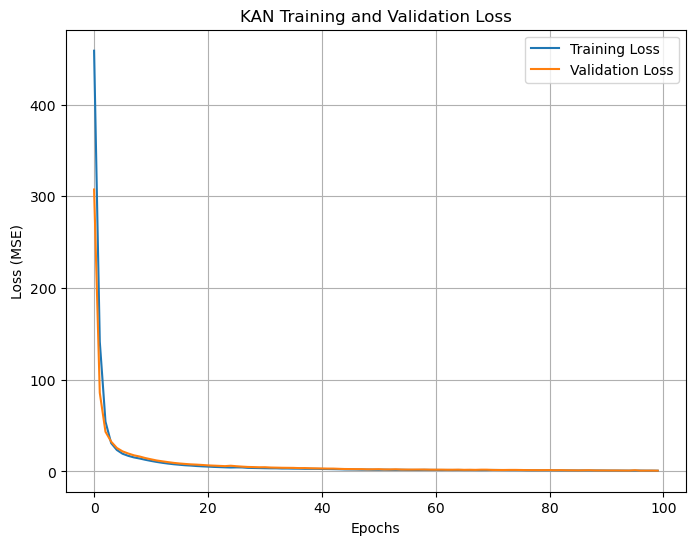

In [19]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('KAN Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()



4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step


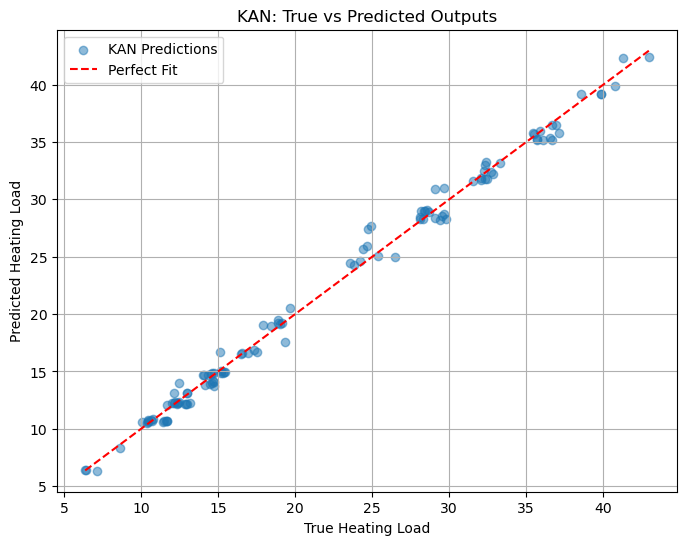

Test MSE: 0.6333
Test R^2: 0.9935


In [20]:
# Predict on the test set
y_pred = kan_model.predict(X_test)

# Scatter plot of True vs Predicted outputs
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='KAN Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Fit')
plt.xlabel("True Heating Load")
plt.ylabel("Predicted Heating Load")
plt.title("KAN: True vs Predicted Outputs")
plt.legend()
plt.grid(True)
plt.show()

# Print evaluation metrics
print(f"Test MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Test R^2: {r2_score(y_test, y_pred):.4f}")


In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_lr_pred = lr_model.predict(X_test)

# 2. Train MLP
mlp_model = MLPRegressor(hidden_layer_sizes=(64, 64), activation='relu', 
                         solver='adam', max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
y_mlp_pred = mlp_model.predict(X_test)

# 3. Evaluate Performance
lr_mse = mean_squared_error(y_test, y_lr_pred)
lr_r2 = r2_score(y_test, y_lr_pred)

mlp_mse = mean_squared_error(y_test, y_mlp_pred)
mlp_r2 = r2_score(y_test, y_mlp_pred)

# KAN Model Predictions
y_kan_pred = kan_model.predict(X_test)
kan_mse = mean_squared_error(y_test, y_kan_pred)
kan_r2 = r2_score(y_test, y_kan_pred)

# Print Performance
print("Performance Summary:")
print(f"Linear Regression: Test MSE = {lr_mse:.4f}, R^2 = {lr_r2:.4f}")
print(f"MLP: Test MSE = {mlp_mse:.4f}, R^2 = {mlp_r2:.4f}")
print(f"KAN: Test MSE = {kan_mse:.4f}, R^2 = {kan_r2:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Performance Summary:
Linear Regression: Test MSE = 7.6781, R^2 = 0.9216
MLP: Test MSE = 2.9639, R^2 = 0.9697
KAN: Test MSE = 0.6333, R^2 = 0.9935


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


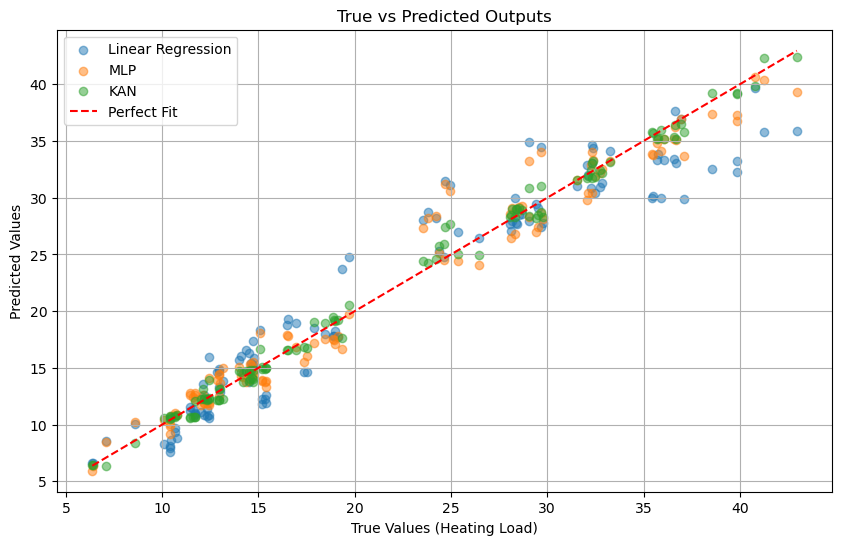

In [22]:
import matplotlib.pyplot as plt

# True vs Predicted Plot for All Models
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_lr_pred, alpha=0.5, label="Linear Regression")
plt.scatter(y_test, y_mlp_pred, alpha=0.5, label="MLP")
plt.scatter(y_test, y_kan_pred, alpha=0.5, label="KAN")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Fit')
plt.xlabel("True Values (Heating Load)")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Outputs")
plt.legend()
plt.grid(True)
plt.show()


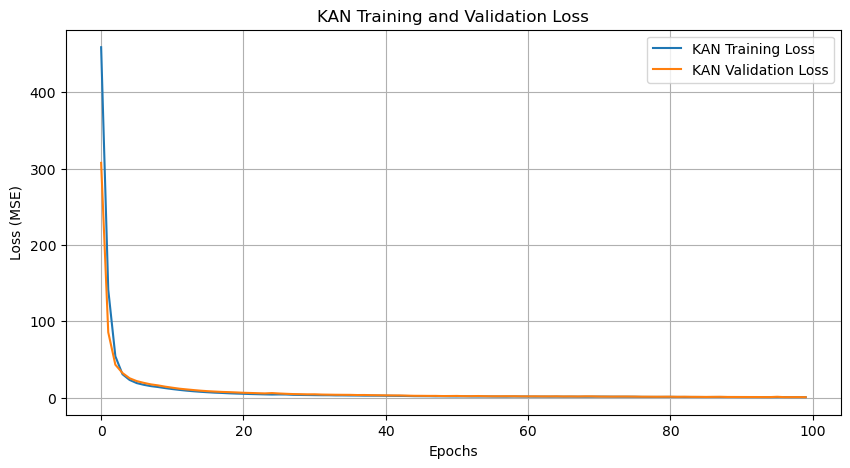

In [23]:
# KAN Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='KAN Training Loss')
plt.plot(history.history['val_loss'], label='KAN Validation Loss')
plt.title("KAN Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()


In [24]:
print("Final Performance Metrics:")
print(f"Linear Regression: MSE = {lr_mse:.4f}, R^2 = {lr_r2:.4f}")
print(f"MLP: MSE = {mlp_mse:.4f}, R^2 = {mlp_r2:.4f}")
print(f"KAN: MSE = {kan_mse:.4f}, R^2 = {kan_r2:.4f}")


Final Performance Metrics:
Linear Regression: MSE = 7.6781, R^2 = 0.9216
MLP: MSE = 2.9639, R^2 = 0.9697
KAN: MSE = 0.6333, R^2 = 0.9935
